In [465]:
import pandas as pd
import numpy as np
from  scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.tools import add_constant
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA

In [466]:
data = pd.read_csv('dog-breed-dataset.csv')
data.head()

,height,tail length,leg length,nose circumference
0,5.151,3.535,1.414,0.202
1,4.949,3.030,1.414,0.202
2,4.747,3.232,1.313,0.202
3,4.646,3.131,1.515,0.202
4,5.050,3.636,1.414,0.202


(300, 4)
(298, 4)
     height  tail length  leg length  nose circumference
0     5.151        3.535       1.414               0.202
1     4.949        3.030       1.414               0.202
2     4.747        3.232       1.313               0.202
3     4.646        3.131       1.515               0.202
4     5.050        3.636       1.414               0.202
..      ...          ...         ...                 ...
295   6.834        3.060       5.304               2.346
296   6.426        2.550       5.100               1.938
297   6.630        3.060       5.304               2.040
298   6.324        3.468       5.508               2.346
299   6.018        3.060       5.202               1.836

[296 rows x 4 columns]


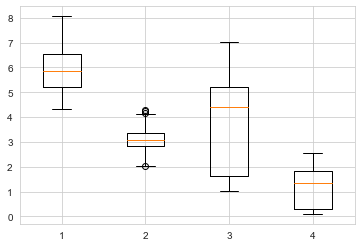

In [467]:
# 1. Data Cleaning
# removing Duplicates
data_copy = data.copy()
print(data_copy.shape)
data_copy = data_copy.drop_duplicates()
# Handling missing values
print(data_copy.dropna().shape)
# Check for outliers using Z_score
z_scores = np.abs(stats.zscore(data_copy, nan_policy='omit'))
outliers_threshold = 3
mask = (z_scores <= outliers_threshold).all(axis=1)
data_copy = data_copy[mask]
print(data_copy)
plt.boxplot(data_copy)
plt.show()

# # Check for outliers using Inter Quartile Range
# data_iqr = data.copy()
# print(data_iqr.shape)
# q1 = np.quantile(data_iqr,0.25)
# q3 = np.quantile(data_iqr,0.75)
# IQR = q3 -q1
# u_bound = q3 + (1.5*IQR)
# l_bound = q1 - (1.5*IQR)
# print(IQR,u_bound,l_bound)
# outliers = data_iqr[(data_iqr <= l_bound) | (data_iqr >= u_bound)].dropna(how='all')
# print(outliers)  # IQR not showing any outliers for the data
# plt.boxplot(data_iqr)
# plt.show()


In [468]:
# Check for Multi-collinearity
vif = pd.DataFrame()
variables = data_copy.columns
df_vif = add_constant(data_copy) 
vif['VIF'] = [VIF(df_vif.values,i) for i in range(df_vif.shape[1])]
vif['variables'] = df_vif.columns
print(vif)
print(data_copy.corr())
data_copy.corr().style.background_gradient(cmap='coolwarm')

# In the below output the vif is higher we can 
# see that there is strong correlation among variables except tail length
# For the given data the higher correlation is expected.

          VIF           variables
0  134.169496               const
1    7.154045              height
2    2.007237         tail length
3   30.873389          leg length
4   15.903905  nose circumference
                      height  tail length  leg length  nose circumference
height              1.000000    -0.117013    0.876963            0.822272
tail length        -0.117013     1.000000   -0.414547           -0.353424
leg length          0.876963    -0.414547    1.000000            0.962610
nose circumference  0.822272    -0.353424    0.962610            1.000000


,height,tail length,leg length,nose circumference
height,1.000000,-0.117013,0.876963,0.822272
tail length,-0.117013,1.000000,-0.414547,-0.353424
leg length,0.876963,-0.414547,1.000000,0.962610
nose circumference,0.822272,-0.353424,0.962610,1.000000


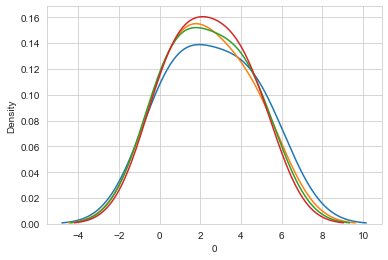

In [469]:
#Find Symmetric distribution of variables ie., not skewed
for i in range(len(data_copy.columns)):
    sns.kdeplot(data_copy.iloc[i])    
plt.show()

# from the plot we can infer that the data is normally distributed


In [470]:
# applying PCA for removing multi collinearity among data

pca = PCA(n_components=4)
components=pca.fit_transform(data_copy)
mu = np.array(np.mean(data_copy,axis=0))
PCA_Df=pd.DataFrame(data=components,columns=['component 1','component 2','component 3','component 4'])


#Reconstructing original Data Frame from PCA
Xhat = (np.matmul(components, pca.components_))+mu

#Calculate VIF 
vif = pd.DataFrame()
vif["features"] = PCA_Df.columns
vif["vif_value"] = [VIF(PCA_Df.values, i) for i in range(PCA_Df.shape[1])]
print(vif)
print(PCA_Df.corr())
PCA_Df.corr().style.background_gradient(cmap='coolwarm')

#Here we can see below that the correlation is removed. 

      features  vif_value
0  component 1        1.0
1  component 2        1.0
2  component 3        1.0
3  component 4        1.0
              component 1   component 2   component 3   component 4
component 1  1.000000e+00  1.238807e-17  9.240273e-17  7.907747e-17
component 2  1.238807e-17  1.000000e+00 -1.527898e-16 -2.089901e-16
component 3  9.240273e-17 -1.527898e-16  1.000000e+00 -7.329555e-17
component 4  7.907747e-17 -2.089901e-16 -7.329555e-17  1.000000e+00


,component 1,component 2,component 3,component 4
component 1,1.000000,0.000000,0.000000,0.000000
component 2,0.000000,1.000000,-0.000000,-0.000000
component 3,0.000000,-0.000000,1.000000,-0.000000
component 4,0.000000,-0.000000,-0.000000,1.000000


In [549]:
# Implementing K-means on data
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score,silhouette_samples
data_copy.reset_index(drop=['index'],inplace=True)



In [ ]:
sse_kmeans = {}
sse_kmeans_pca = {}
clustered_df = pd.DataFrame()
clustered_df = data_copy.copy()
for i in range(2,7):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(data_copy)
    kmeans_pca = KMeans(n_clusters=i, random_state=0).fit(PCA_Df)
    gaussian = GaussianMixture(n_components=i, random_state=0).fit(data_copy) 
    
    clustered_df[f'labels_kmeans_{i}'] = kmeans.predict(data_copy)
    clustered_df[f'labels_kmeans_pca_{i}'] = kmeans_pca.predict(PCA_Df)
    clustered_df[f'labels_GMM_{i}'] = gaussian.predict(data_copy)
    sse_kmeans[i] = kmeans.inertia_ 
    sse_kmeans_pca[i] = kmeans_pca.inertia_ 

    clustered_df[f'kmeans_silhouette_values_{i}'] = silhouette_samples(clustered_df, clustered_df[f'labels_kmeans_{i}'])
    clustered_df[f'pca_kmeans_silhouette_values_{i}'] = silhouette_samples(clustered_df, clustered_df[f'labels_kmeans_pca_{i}'])
    clustered_df[f'labels_GMM_silhouette_values_{i}'] = silhouette_samples(clustered_df, clustered_df[f'labels_GMM_{i}'])


In [557]:
clustered_df

,height,tail length,leg length,nose circumference,labels_kmeans_2,labels_kmeans_pca_2,labels_GMM_2,kmeans_silhouette_values_2,pca_kmeans_silhouette_values_2,labels_GMM_silhouette_values_2,...,labels_GMM_5,kmeans_silhouette_values_5,pca_kmeans_silhouette_values_5,labels_GMM_silhouette_values_5,labels_kmeans_6,labels_kmeans_pca_6,labels_GMM_6,kmeans_silhouette_values_6,pca_kmeans_silhouette_values_6,labels_GMM_silhouette_values_6
0,5.151,3.535,1.414,0.202,1,0,1,0.546940,0.513988,0.141785,...,3,0.945495,0.482064,0.945513,3,0,3,0.945457,0.945467,0.945480
1,4.949,3.030,1.414,0.202,1,0,0,0.523380,0.496760,0.951300,...,0,0.945161,0.368368,0.945153,0,4,0,0.945149,0.944958,0.945156
2,4.747,3.232,1.313,0.202,1,0,0,0.529135,0.502441,0.954323,...,0,0.948799,0.377752,0.948786,0,4,0,0.948782,0.948601,0.948791
3,4.646,3.131,1.515,0.202,1,0,0,0.524383,0.497857,0.953497,...,0,0.947671,0.370322,0.947665,0,4,0,0.947662,0.947487,0.947674
4,5.050,3.636,1.414,0.202,1,0,1,0.546489,0.513677,0.138399,...,3,0.942209,0.481857,0.942226,3,0,3,0.942165,0.942174,0.942183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,6.834,3.060,5.304,2.346,0,1,1,0.431659,0.425655,0.424566,...,2,0.566148,0.644792,0.566842,2,3,2,0.868531,0.709937,0.868339
292,6.426,2.550,5.100,1.938,0,1,1,0.376892,0.387814,0.342165,...,1,0.823933,0.835171,0.823381,1,1,1,0.737897,0.787962,0.740396
293,6.630,3.060,5.304,2.040,0,1,1,0.338193,0.340827,0.245406,...,1,0.552215,-0.302461,0.547405,1,3,1,0.241449,-0.002677,0.256416
294,6.324,3.468,5.508,2.346,0,1,1,0.427497,0.421320,0.421528,...,2,0.550892,0.635924,0.551613,2,3,2,0.850086,0.697201,0.849857


<AxesSubplot:xlabel='height', ylabel='leg length'>

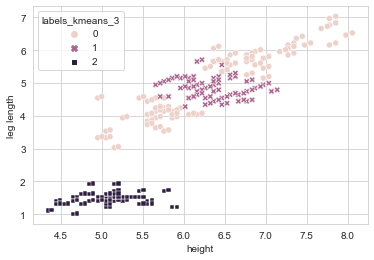

In [558]:
sns.scatterplot(data=clustered_df, x='height',y='leg length',hue='labels_kmeans_3',style="labels_kmeans_3")

<AxesSubplot:xlabel='height', ylabel='nose circumference'>

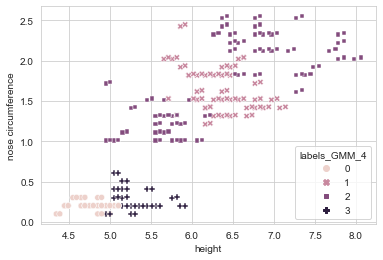

In [559]:
sns.scatterplot(data=clustered_df, x='height',y='nose circumference',hue='labels_GMM_4',style="labels_GMM_4")


#In the below plot, the 4 clusters are overlapped.

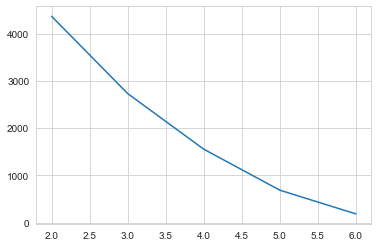

In [560]:
plt.figure()
plt.plot(list(sse_kmeans.keys()), list(sse_kmeans.values()))

#The below elbow graph suggests k value 4 

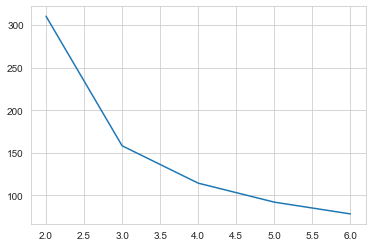

In [562]:
plt.figure()
plt.plot(list(sse_kmeans_pca.keys()), list(sse_kmeans_pca.values()))

# The below elbow graph suggests k value 3 

<AxesSubplot:xlabel='height', ylabel='nose circumference'>

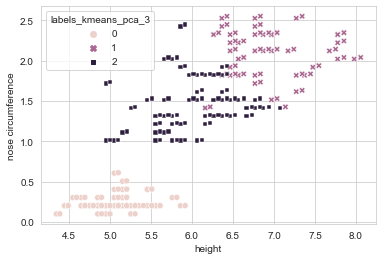

In [563]:
sns.scatterplot(data=clustered_df, x='height',y='nose circumference',hue='labels_kmeans_pca_3',style="labels_kmeans_pca_3")

#From the below the 3 clusters are very obvious with very few over lapping observations.

<AxesSubplot:xlabel='height', ylabel='nose circumference'>

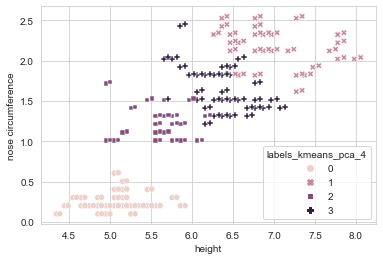

In [545]:
sns.scatterplot(data=clustered_df, x='height',y='nose circumference',hue='labels_kmeans_pca_4',style="labels_kmeans_pca_4")

#From the below the even 4 clusters are very obvious with very few overlapping observations.

In [566]:
# Cluster validation
silhouette_avg_kmeans = {}
silhouette_avg_kmeans_pca = {}
silhouette_avg_GMM = {}

for i in range(2,7):
    silhouette_avg_kmeans[i] = silhouette_score(clustered_df, clustered_df[f'labels_kmeans_{i}'])
    silhouette_avg_kmeans_pca[i] = silhouette_score(clustered_df, clustered_df[f'labels_kmeans_pca_{i}'])
    silhouette_avg_GMM[i] = silhouette_score(clustered_df, clustered_df[f'labels_GMM_{i}'])

    print(silhouette_avg_kmeans[i])
    print(silhouette_avg_kmeans_pca[i])
    print(silhouette_avg_GMM[i])
    


0.4206888265163931
0.3967059842723722
0.43817962064290317
0.4854459623177101
0.313691539410473
0.47343523141980387
0.6608938261802226
0.5514393611883335
0.6608938261802226
0.746324187723541
0.632199943409062
0.746324187723541
0.8298303590087474
0.8122430053090429
0.8298303590087474


In [567]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [627]:
af = AffinityPropagation(preference=-75, random_state=0).fit(PCA_Df)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
af_proposed_labels = set(labels)
print(af_proposed_labels)
print("Homogenity : %.2f" % metrics.homogeneity_score(clustered_df[f'labels_kmeans_pca_{len(af_proposed_labels)}'], labels))
print("Completeness : %.2f" % metrics.completeness_score(clustered_df[f'labels_kmeans_pca_{len(af_proposed_labels)}'], labels))
print("v-measure score : %.2f" % metrics.v_measure_score(clustered_df[f'labels_kmeans_pca_{len(af_proposed_labels)}'], labels))
print("adjusted_rand_score : %.2f" % metrics.adjusted_rand_score(clustered_df[f'labels_kmeans_pca_{len(af_proposed_labels)}'], labels))
print("adjusted_mutual_info_score : %.2f" % metrics.adjusted_mutual_info_score(clustered_df[f'labels_kmeans_pca_{len(af_proposed_labels)}'], labels))


{0, 1, 2, 3}
Homogenity : 0.90
Completeness : 0.90
v-measure score : 0.90
adjusted_rand_score : 0.90
adjusted_mutual_info_score : 0.90
silhouette_score : 0.68


In [631]:
print("silhouette_score : %.2f" % metrics.silhouette_score(clustered_df, clustered_df['labels_kmeans_6'], metric="sqeuclidean"))


silhouette_score : 0.94


0.8955172200624189